
**Install requirements**

In [0]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm
from sklearn import model_selection
import numpy as np


**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # There is an extra Background class that will be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2*5         #1e-3 The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 25     #30 Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([#transforms.RandomCrop(256, pad_if_needed=True),
                                      transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the imag
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      #transforms.RandomGrayscale(p=0.1),
                                      #transforms.RandomHorizontalFlip(p=0.1),
                                      #transforms.RandomApply(transforms.ColorJitter(), p=0.1),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation of imageNet
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

**Prepare Dataset**

In [4]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/usesnames/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

stratSplit = model_selection.StratifiedShuffleSplit(n_splits=1, train_size=0.5, random_state = 42)

train_indexes, val_indexes =  next(stratSplit.split(np.zeros(len(train_dataset)), train_dataset.labels)) # split the indices

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)


# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [0]:
net = alexnet(pretrained=True) # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: --> net.features.parameters()
parameters_to_optimize = net.classifier.parameters() 

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [8]:
import copy
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

models = []
current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
  

  models.append(copy.deepcopy(net.state_dict()))
  # Step the scheduler
  scheduler.step() 

Starting epoch 1/25, LR = [0.05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.9684858322143555
Step 10, Loss 1.0495713949203491
Starting epoch 2/25, LR = [0.05]
Step 20, Loss 0.25164568424224854
Starting epoch 3/25, LR = [0.05]
Step 30, Loss 0.07727991789579391
Starting epoch 4/25, LR = [0.05]
Step 40, Loss 0.06665091216564178
Starting epoch 5/25, LR = [0.05]
Step 50, Loss 0.030170749872922897
Starting epoch 6/25, LR = [0.05]
Step 60, Loss 0.0344347283244133
Starting epoch 7/25, LR = [0.05]
Step 70, Loss 0.022880325093865395
Starting epoch 8/25, LR = [0.05]
Step 80, Loss 0.00896001048386097
Starting epoch 9/25, LR = [0.05]
Step 90, Loss 0.0049081481993198395
Starting epoch 10/25, LR = [0.05]
Step 100, Loss 0.002072896808385849
Starting epoch 11/25, LR = [0.0005000000000000001]
Step 110, Loss 0.022969160228967667
Step 120, Loss 0.004306059330701828
Starting epoch 12/25, LR = [0.005000000000000001]
Step 130, Loss 0.002416599541902542
Starting epoch 13/25, LR = [0.005000000000000001]
Step 140, Loss 0.004389379173517227
Starting epoch 14/25, LR = [0.0

**Validation**

In [9]:
accuracies = []

for mo in models:

  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode
  net.load_state_dict(mo)

  running_corrects = 0
  for images, labels in tqdm(val_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()
    
  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))
  accuracies.append(accuracy)

best_model = models[accuracies.index(max(accuracies))]
print('Best Validation Accuracy: {}'.format(max(accuracies)))

100%|██████████| 12/12 [00:08<00:00,  1.35it/s]

Best Validation Accuracy: 0.838865836791148


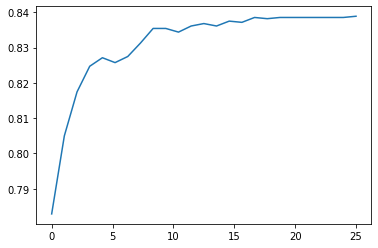

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(np.linspace(0, NUM_EPOCHS, NUM_EPOCHS), accuracies)
plt.show()

**Test**

In [13]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode
net.load_state_dict(best_net)

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

#TO-DO
#tune data aug
#freeze only part of conv layers

100%|██████████| 12/12 [00:09<00:00,  1.23it/s]

Test Accuracy: 0.8492913930176288
